# Credit Card Approval Prediction

## Table of contents

### [Problems](#1)
### [Dataset](#2)
### [Import libraries](#3)
### [Data overview](#5)
### [Univariate analysis](#6)
* #### [Function define](#7)
* #### [Age](#8)
* #### [Income](#9)
* #### [Employment length](#10)
* #### [Account age](#11)
* #### [Is high risk](#12)

### [Bivariate analysis](#13)
### [Data preprocessing](#14)
* #### [Feature selection](#15)
* #### [Feature engineering](#16)

### [Model selection](#17)
### [Conclusion](#18)
### [Limitation](#19)

<a id="1"></a>
## Problems
The objective of credit card approval prediction is to develop a model that can accurately predict whether a credit card application should be approved or rejected based on various features and applicant information. The aim is to automate the decision-making process and assist financial institutions in making informed and consistent credit card approval decisions.

<a id="2"></a>
## Dataset
#### --> **application_record.csv**
1. **ID**: Client number or identifier for each individual applicant.
2. **CODE_GENDER**: Gender of the applicant (e.g., Male, Female).
3. **FLAG_OWN_CAR**: Indicates whether the applicant owns a car (Yes/No).
4. **FLAG_OWN_REALTY**: Indicates whether the applicant owns real estate (property) (Yes/No).
5. **CNT_CHILDREN**: Number of children the applicant has.
6. **AMT_INCOME_TOTAL**: Annual income of the applicant.
7. **NAME_INCOME_TYPE**: Categorization of the applicant's income type (e.g., employed, self-employed, student, etc.).
8. **NAME_EDUCATION_TYPE**: Education level of the applicant (e.g., secondary, higher education, etc.).
9. **NAME_FAMILY_STATUS**: Marital status of the applicant.
10. **NAME_HOUSING_TYPE**: Type of housing or living arrangement for the applicant.
11. **DAYS_BIRTH**: Age of the applicant in days, counting backwards from the current day. For example, 0 represents the current day, -1 represents yesterday.
12. **DAYS_EMPLOYED**: Start date of employment for the applicant, counting backwards from the current day. If the value is positive, it indicates that the person is currently unemployed.
13. **FLAG_MOBIL**: Indicates whether the applicant has a mobile phone (Yes/No).
14. **FLAG_WORK_PHONE**: Indicates whether the applicant has a work phone (Yes/No).
15. **FLAG_PHONE**: Indicates whether the applicant has a phone (Yes/No).
16. **FLAG_EMAIL**: Indicates whether the applicant has an email (Yes/No).
17. **OCCUPATION_TYPE**: Occupation or job type of the applicant.
18. **CNT_FAM_MEMBERS**: Number of family members or family size.

#### --> **credit_record.csv**
1. **ID**: Client number or identifier for each individual applicant.
2. **MONTHS_BALANC**E: The record month indicates the starting point of the extracted data. It is represented as a backward count from the current month. For example, 0 represents the current month, -1 represents the previous month, -2 represents two months ago, and so on.
3. **STATUS**: The status column represents the loan status for each month. The codes and their corresponding meanings are as follows:
* *0: 1-29 days past due*
* *1: 30-59 days past due*
* *2: 60-89 days overdue*
* *3: 90-119 days overdue*
* *4: 120-149 days overdue*
* *5: Overdue or bad debts, write-offs for more than 150 days*
* *C: Paid off that month*
* *X: No loan for the month*

<a id="3"></a>
## Importing libraries

In [1]:
# General
import numpy as np
import pandas as pd
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Others
import os
import warnings
import itertools

<a id="4"></a>
## Create a target variable

In [2]:
app = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')
credit = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')

In [3]:
begin_month=pd.DataFrame(credit.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
app=pd.merge(app,begin_month,how='left',on='ID')
credit['dep_value'] = None
credit['dep_value'][credit['STATUS'] =='2']='Yes'
credit['dep_value'][credit['STATUS'] =='3']='Yes'
credit['dep_value'][credit['STATUS'] =='4']='Yes'
credit['dep_value'][credit['STATUS'] =='5']='Yes'
cpunt=credit.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
app = pd.merge(app,cpunt,how='inner',on='ID')
app['Is high risk']=app['dep_value']
app.loc[app['Is high risk']=='Yes','Is high risk']=1
app.loc[app['Is high risk']=='No','Is high risk']=0
app.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

/tmp/ipykernel_32/1424979425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit['dep_value'][credit['STATUS'] =='2']='Yes'
/tmp/ipykernel_32/1424979425.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit['dep_value'][credit['STATUS'] =='3']='Yes'
/tmp/ipykernel_32/1424979425.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit['dep_value'][credit['STATUS'] =='4']='Yes'
/tmp/ipykernel_32/1424979425.py:8: SettingWith

<a id="5"></a>
## Data overview

In [4]:
app.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'Account age',
       'Is high risk'],
      dtype='object')

##### For the sake of convenient analysis, I change the name of columns to make them more readable

In [5]:
app = app.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

In [6]:
app.columns

Index(['ID', 'Gender', 'Has a car', 'Has a property', 'Children count',
       'Income', 'Employment status', 'Education level', 'Marital status',
       'Dwelling', 'Age', 'Employment length', 'Has a mobile phone',
       'Has a work phone', 'Has a phone', 'Has an email', 'Job title',
       'Family member count', 'Account age', 'Is high risk'],
      dtype='object')

<Axes: >

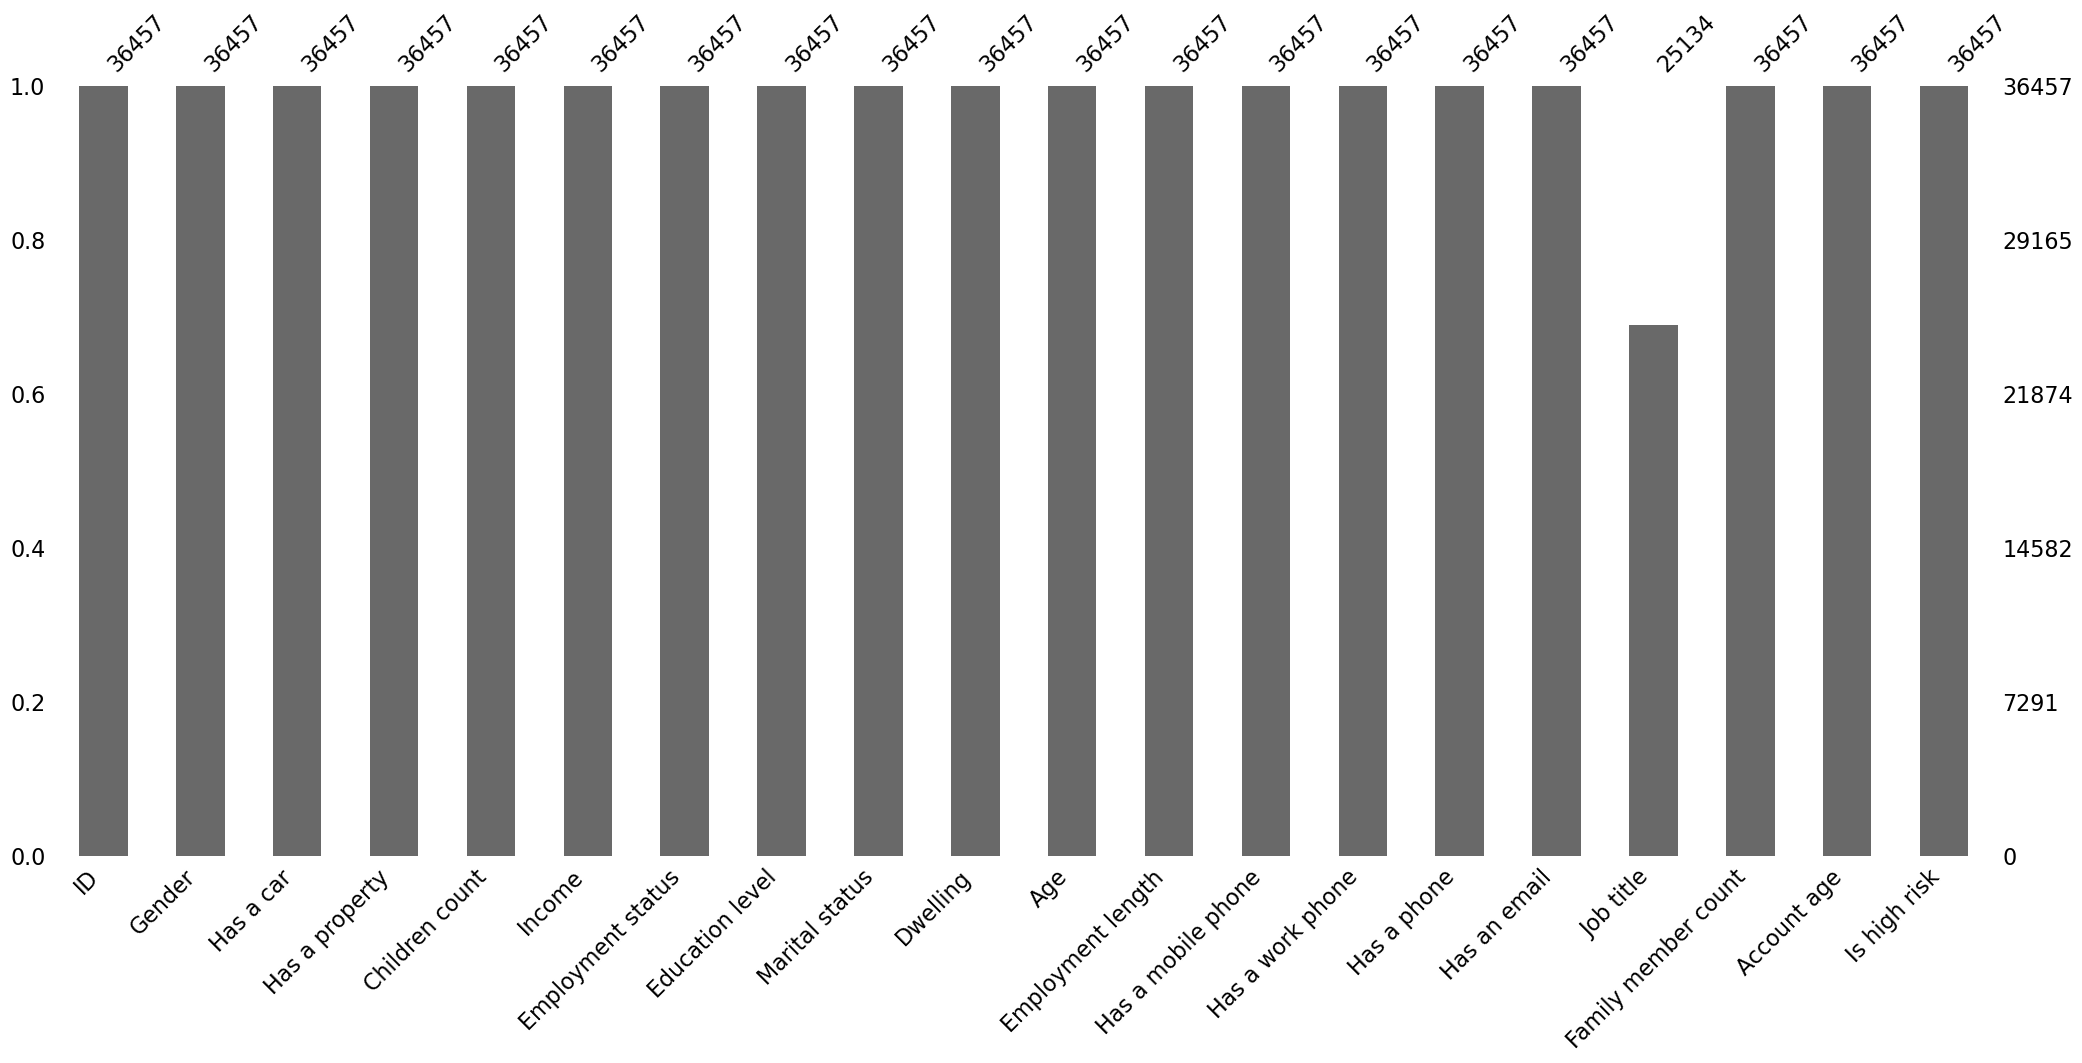

In [7]:
msno.bar(app)

#### There are missing values in job title, we will consider it in further analysis

In [8]:
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [9]:
app.describe()

ID  Children count        Income           Age  \
count  3.645700e+04    36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06        0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04        0.742367  1.017892e+05   4200.549944   
min    5.008804e+06        0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06        0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06        0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06        1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06       19.000000  1.575000e+06  -7489.000000   

       Employment length  Has a mobile phone  Has a work phone   Has a phone  \
count       36457.000000             36457.0      36457.000000  36457.000000   
mean        59262.935568                 1.0          0.225526      0.294813   
std        137651.334859                 0.0          0.417934      0.455965   
min        -15713.000000                 1.0          0.000000      0.000000   
25%         -3153.000000                 1.0          0.000000      0.000000   
50%         -1552.000000                 1.0          0.000000      0.000000   
75%          -408.000000                 1.0          0.000000      1.000000   
max        365243.000000                 1.0          1.000000      1.000000   

       Has an email  Family member count   Account age  
count  36457.000000         36457.000000  36457.000000  
mean       0.089722             2.198453    -26.164193  
std        0.285787             0.911686     16.501854  
min        0.000000             1.000000    -60.000000  
25%        0.000000             2.000000    -39.000000  
50%        0.000000             2.000000    -24.000000  
75%        0.000000             3.000000    -12.000000  
max        1.000000            20.000000      0.000000

##### There are some key insights when we look at these statistics:
* **'Children count'**: At max value, there are 19 childrens in 1 family.
* **'Has a mobile phone'**: Every one has a mobile phone.
* **'Family member count'**: At max value, there are 20 people in 1 family.
* **'Age','Employment length','Account age'** are presented in negative days.

In [10]:
from IPython.core.display import HTML

#Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
def multi_table(table_list):
        return HTML('<table><tr style="background-color:white;">' +  ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +'</tr></table>')

In [11]:
nunique_df={var:pd.DataFrame(app[var].value_counts())
           for var in {'Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling','Job title','Is high risk'}}

multi_table([nunique_df['Gender'],nunique_df['Has a car'],nunique_df['Has a property'],nunique_df['Employment status'],nunique_df['Education level'],nunique_df['Marital status'],nunique_df['Dwelling'],nunique_df['Job title'],nunique_df['Is high risk']])

<a id="6"></a>
## Univariate analysis

<a id="7"></a>
### Function define

In [12]:
def plot_bar(df, feature):
    '''A function to create Histogram'''
    match feature:
        case 'Age':
            bins = np.abs(df[feature])/365.25
            fig=px.histogram(data_frame=df,x=bins,
                             title='Distribution of {} in year'.format(feature),
                             labels={'x':feature, 'y':'count'},
                             template='simple_white')
            colors = ['#090580',] * df[feature].nunique()
            fig.update_layout(bargap=0.1,
                              width=800, height=500)
            fig.update_traces(marker_color=colors, marker_line_color=None,
                              marker_line_width=2.5, opacity=None)
            fig.show()
            
        case 'Employment length':
            employment_len_no_ret = app['Employment length'][app['Employment length'] < 0]
            bins = np.abs(employment_len_no_ret)/365.25
            fig=px.histogram(x=bins,
                             title='Distribution of {} in year'.format(feature),
                             labels={'x':feature, 'y':'count'},
                             template='simple_white')
            colors = ['#090580',] * df[feature].nunique()
            fig.update_layout(bargap=0.1,
                              width=800, height=500)
            fig.update_traces(marker_color=colors, marker_line_color=None,
                              marker_line_width=2.5, opacity=None)
            fig.show()
            
        case 'Income':
            fig=px.histogram(data_frame=df,x=feature,nbins=100,
                             title='Distribution of {}'.format(feature),
                             labels={'x':feature, 'y':'count'},
                             width=800, height=500,
                             template='simple_white')
            colors = ['#090580',] * df[feature].nunique()
            fig.update_traces(marker_color=colors, marker_line_color=None,
                              marker_line_width=2.5, opacity=None)
            fig.show()
            
        case 'Account age':
            fig=px.histogram(data_frame=df,x=np.abs(df[feature]),
                             title='Distribution of {}'.format(feature),
                             labels={'x':feature,'y':'count'},
                             template='simple_white')
            colors = ['#090580',] * df[feature].nunique()
            fig.update_layout(bargap=0.1,
                              width=800, height=500)
            fig.update_traces(marker_color=colors, marker_line_color=None,
                              marker_line_width=2.5, opacity=None)
            fig.show()

In [13]:
def plot_box(df, feature):
    '''A function to create Boxplot'''
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig=px.box(data_frame=df,y=np.abs(app['Age'])/365.25,color=app['Is high risk'],
                       title='High risk individuals grouped by {}'.format(feature),
                       labels={'y':'Age'},
                       width=600, height=500,
                       template='simple_white')
            fig.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig=px.box(data_frame=df,y=feature,color=app['Is high risk'],
                       title='High risk individuals grouped by {}'.format(feature),
                       labels={'y':'Income'},
                       width=600, height=500,
                       template='simple_white')
            fig.show()
        case 'Employment length':
            # checking is an applicant is high risk or not (for those who have negative employment length mean only those who are employed)
            employment_no_ret = app['Employment length'][app['Employment length'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            # extract those who are employed from the original dataframe and return only the employment length and Is high risk columns
            employment_no_ret_df = app.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig=px.box(data_frame=df,y=employment_len_no_ret_yrs,color=employment_no_ret_df['Is high risk'],
                       title='High risk individuals grouped by {}'.format(feature),
                       labels={'y':'Employment length'},
                       width=800, height=500,
                       template='simple_white')
            fig.show()
        case 'Account age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig=px.box(data_frame=df,y=np.abs(app['Age']),color=app['Is high risk'],
                       title='High risk individuals grouped by {}'.format(feature),
                       labels={'y':'Account age'},
                       width=600, height=500,
                       template='simple_white')
            fig.show()

<a id="8"></a>
### Age vs

In [14]:
plot_bar(app,'Age')

In [15]:
plot_box(app,'Age')

Is high risk
0    43.739870
1    43.607954
Name: Age, dtype: float64


**Observations:**
* Age is not normally distributed; it is slightly positively skewed.
* No significant difference between the age of those who are high risk and those who are not.
* The mean age for both groups is around 43 years old, and there is no correlation between the age and risk factors of the applicant.

<a id="9"></a>
### Income

In [16]:
plot_bar(app,'Income')

In [17]:
plot_box(app,'Income')

Is high risk
0    186699.846740
1    185864.763799
Name: Income, dtype: float64


**Observations:**
* The average mean income is 186890, but this amount factors in outliers.
* Most people make 157500 (median income) if we ignore the outliers.
* We have 3 applicants who make more than 1000000.
* This feature is also positively skewed.
* The income box plot of good and bad clients, they all have roughly similar incomes.

<a id="10"></a>
### Employment Length

In [18]:
plot_bar(app,'Employment length')

In [19]:
plot_box(app,'Employment length')

Is high risk
0    7.263873
1    6.005277
Name: Employment length, dtype: float64


**Observations:**
* Most applicants have been working between 5 to 7 years on average, and we also have many outliers who have been working for more than 20 years+.
* The employment length histogram is positively skewed.
* Bad clients have a low employment length of 5 versus 7 years for good clients.

<a id="11"></a>
### Account age

In [20]:
plot_bar(app,'Account age')

In [21]:
plot_box(app,'Account age')

Is high risk
0    26.033928
1    33.743506
Name: Account age, dtype: float64


**Observations:**
* The account age feature is not normally distributed; it is positively skewed.
* On average, bad clients’ accounts are 34 months old vs 26 months old for good clients’ accounts.

<a id="12"></a>
### Is high risk

In [22]:
ftr_cnt = app['Is high risk'].value_counts()
fig=px.pie(values=ftr_cnt,
           names=ftr_cnt.index,
           title='Distribution of Is high risk',
           width=500,height=500,
           template='simple_white')
fig.update_traces(hoverinfo='label+value',
                  textinfo='label+percent',
                  textfont_size=12,
marker=dict(colors=['#090580','#E8A9A9'],
            line=dict(color='#000000',
            width=2)))
fig.show()

**Observations:**
* Most applicants are good clients (98% of applicants). We have imbalanced data that needs to be balanced using SMOTE before training on a model.

*Note: 1 is yes, 0 is no.*

<a id="13"></a>
## Bivariate analysis

In [23]:
pairplot=app[app['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1)
fig=go.Figure(data=go.Splom(
              dimensions=[dict(label='Age',
                               values=pairplot['Age']),
                          dict(label='Children count',
                               values=pairplot['Children count']),
                          dict(label='Income',
                               values=pairplot['Income']),
                          dict(label='Family member count',
                               values=pairplot['Family member count']),
                          dict(label='Employment length',
                               values=pairplot['Employment length']),
                          dict(label='Account age',
                               values=pairplot['Account age'])],
              showupperhalf=False))
fig.update_layout(
    title='Pairplot',
    dragmode='select',
    width=1100, height=1100,
    hovermode='closest')
fig.show()

**Observations:**
* The more children a person has, the larger the family count.
* The applicants’ age increases with the employment length.

/tmp/ipykernel_32/1272174134.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



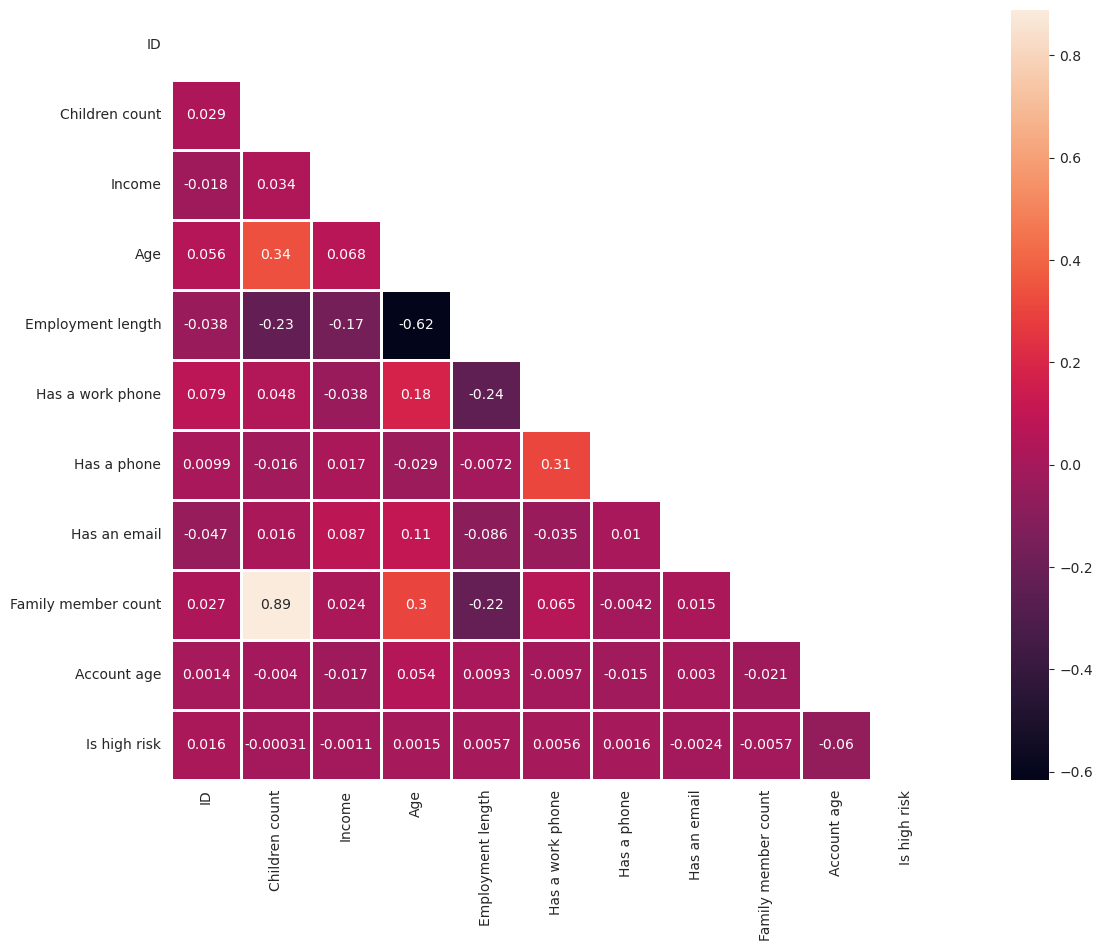

In [24]:
target_int=app['Is high risk'].astype('int32')
no_mobile=pd.concat([app.drop(['Has a mobile phone','Is high risk'],axis=1),target_int],axis=1).corr()
mask = np.zeros_like(no_mobile,dtype='bool')
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(18, 10))
    ax = sns.heatmap(no_mobile,mask=mask,square=True,linewidths=.8,annot=True)

**Observations:**
* No feature is correlated with the target feature (Which is high risk).
* We see a strong correlation (0.89) between **family member count** and **children count**.
* **Age** has some positive correlation (0.3) with the **family member count** and **children count**.
* Another positive correlation (0.31) is **has a phone** and **has a work phone**.
* A slightly positive correlation between **age** and **has a work phone** (0.18); younger people will be less likely to own a work phone.
* We also have a negative (-0.62) between **employment length** and **age**.
* There is also a negative (-0.22) between **employment length** and **family member count**.

<a id="14"></a>
# Data preprocessing

<a id="15"></a>
#### Feature selection
* **ID**: ID is not helpful for prediction, it helped us when we were merging the two datasets, but after that, there is no need to keep it.
* **Has a mobile phone**: Since everyone has a mobile phone, this feature does not inform us about anything and is useless for the model.
* **Children count**: is highly correlated with Family member count, and to avoid multicollinearity, we will drop it.
* **Job title**: Has some missing values and the count of each category is not very different to justify using the mode to fill the missing values. So we drop it.
* **Account age**: Because Account age is used to create the target, reusing it will make our model overfit. Plus, this information is unknown while applying for a credit card and is not a predictor feature.

In [25]:
app.drop(['ID','Has a mobile phone','Children count','Job title','Account age'], axis=1, inplace=True) 

<a id="16"></a>
### Feature engineering
For **Age, Employment** length are containing negative values, so I change the values to positive using numpy.

In [26]:
app[['Age','Employment length']]=np.abs(app[['Age','Employment length']])

Convert the **employment length** of retirees (set to 365243) to 0 so that it is not considered an outlier.

In [27]:
df_ret_idx = app['Employment length'][app['Employment length'] == 365243].index
app.loc[df_ret_idx,'Employment length'] = 0

Using the cubic root transformation, this class will reduce **income** and **age** distribution skewness.

In [28]:
app[['Income','Age']] = np.cbrt(app[['Income','Age']])

Parse the data type object.

In [29]:
objects_data = pd.DataFrame(app.dtypes =='object').reset_index()
object_type = objects_data[objects_data[0] == True]['index']
object_type

0                Gender
1             Has a car
2        Has a property
4     Employment status
5       Education level
6        Marital status
7              Dwelling
14         Is high risk
Name: index, dtype: object

Now, let's convert all non-numeric data to numeric data using **LabelEncoder()**

In [30]:
le = LabelEncoder()
for x in app:
    if app[x].dtypes == 'object':
        app[x] = le.fit_transform(app[x])

Oversample the target variable using SMOTE because the minority class (Is high risk = 1) is scarce in the data.

In [31]:
oversample=SMOTE(sampling_strategy='minority')
X_bal, y_bal=oversample.fit_resample(app.loc[:, app.columns != 'Is high risk'],app['Is high risk'])
app = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)

#### Data splitting

In [32]:
X = app.iloc[:,1:-1] # X value contains all the variables except labels
y = app.iloc[:,-1] # these are the labels

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<a id="17"></a>
# Model selections
I will consider following models:
* DecisionTreeClassifier()
* GaussianNB()
* AdaBoostClassifier()
* KNeighborsClassifier()
* GradientBoostingClassifier()
* RandomForestClassifier()

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy Score is 0.9769356
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10719
           1       0.98      0.98      0.98     10786

    accuracy                           0.98     21505
   macro avg       0.98      0.98      0.98     21505
weighted avg       0.98      0.98      0.98     21505

Normalized confusion matrix
[[0.97650788 0.02349212]
 [0.02263871 0.97736129]]


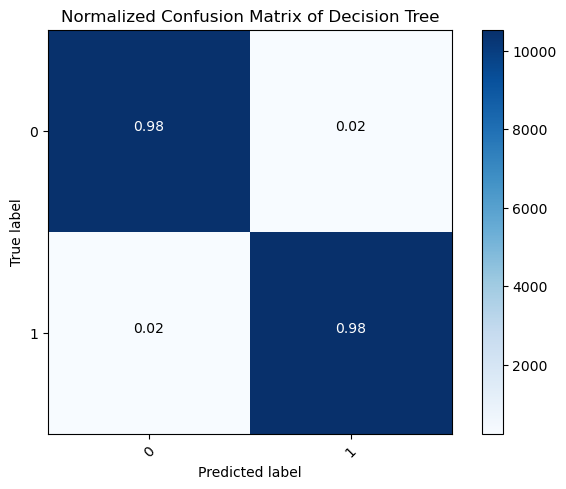

In [35]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train) #  training the model
y_predict = model.predict(X_test) # make predictions on X_test
class_names = ['0','1']
print('Accuracy Score is {:.7}'.format(accuracy_score(y_test, y_predict))) # compare Y_test and Y_predict
print(classification_report(y_predict, y_test)) # confusion matrix on Y_test and Y_predict

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix of Decision Tree')

Accuracy Score is 0.6499884
              precision    recall  f1-score   support

           0       0.49      0.72      0.58      7264
           1       0.81      0.61      0.70     14241

    accuracy                           0.65     21505
   macro avg       0.65      0.67      0.64     21505
weighted avg       0.70      0.65      0.66     21505

Normalized confusion matrix
[[0.48774121 0.51225879]
 [0.1885322  0.8114678 ]]


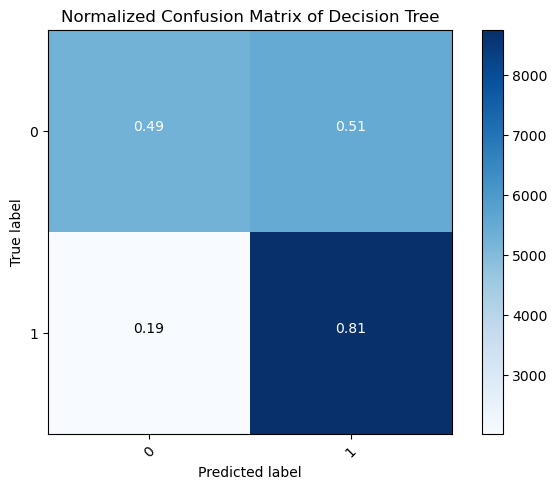

In [36]:
model = GaussianNB()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
class_names = ['0','1']
print('Accuracy Score is {:.7}'.format(accuracy_score(y_test, y_predict)))
print(classification_report(y_predict, y_test))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix of Decision Tree')

Accuracy Score is 0.7709835
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     11540
           1       0.73      0.79      0.76      9965

    accuracy                           0.77     21505
   macro avg       0.77      0.77      0.77     21505
weighted avg       0.77      0.77      0.77     21505

Normalized confusion matrix
[[0.80833411 0.19166589]
 [0.26619039 0.73380961]]


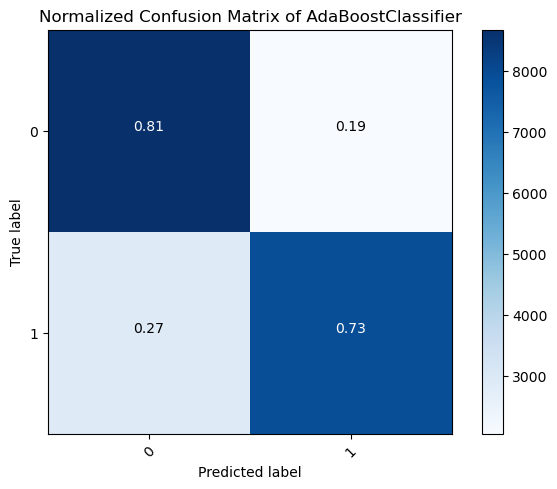

In [37]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
class_names = ['0','1']
print('Accuracy Score is {:.7}'.format(accuracy_score(y_test, y_predict)))
print(classification_report(y_predict, y_test))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix of AdaBoostClassifier')

Accuracy Score is 0.9334573
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     10160
           1       0.96      0.91      0.94     11345

    accuracy                           0.93     21505
   macro avg       0.93      0.93      0.93     21505
weighted avg       0.93      0.93      0.93     21505

Normalized confusion matrix
[[0.90687051 0.09312949]
 [0.04008165 0.95991835]]


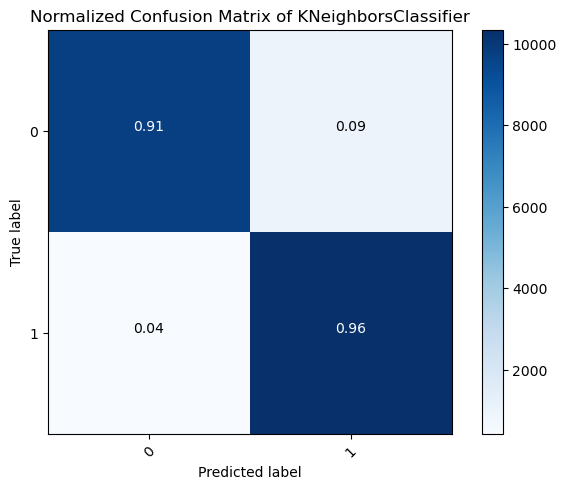

In [38]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
class_names = ['0','1']
print('Accuracy Score is {:.7}'.format(accuracy_score(y_test, y_predict)))
print(classification_report(y_predict, y_test))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix of KNeighborsClassifier')

Accuracy Score is 0.8491979
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     11586
           1       0.81      0.88      0.84      9919

    accuracy                           0.85     21505
   macro avg       0.85      0.85      0.85     21505
weighted avg       0.85      0.85      0.85     21505

Normalized confusion matrix
[[0.88887853 0.11112147]
 [0.19029505 0.80970495]]


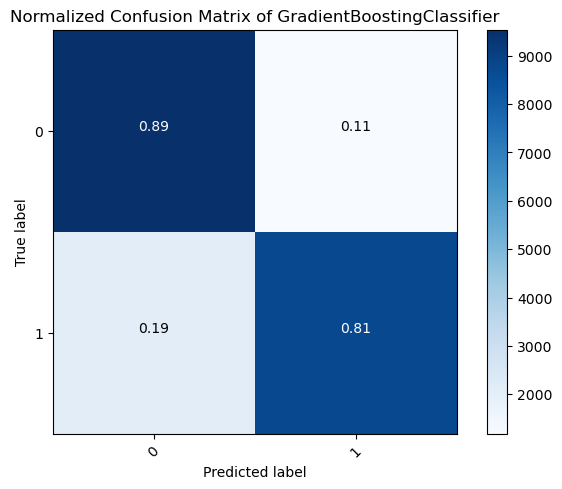

In [39]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
class_names = ['0','1']
print('Accuracy Score is {:.7}'.format(accuracy_score(y_test, y_predict)))
print(classification_report(y_predict, y_test))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix of GradientBoostingClassifier')

Accuracy Score is 0.9853057
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10659
           1       0.99      0.98      0.99     10846

    accuracy                           0.99     21505
   macro avg       0.99      0.99      0.99     21505
weighted avg       0.99      0.99      0.99     21505

Normalized confusion matrix
[[0.98210124 0.01789876]
 [0.01150492 0.98849508]]


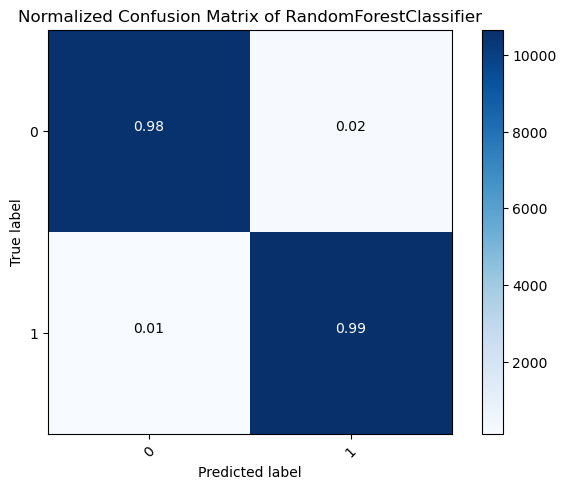

In [40]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
class_names = ['0','1']
print('Accuracy Score is {:.7}'.format(accuracy_score(y_test, y_predict)))
print(classification_report(y_predict, y_test))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix of RandomForestClassifier')

<a id="18"></a>
## Conclusion

##### Top 3 models (with default parameters):
1. **RandomForestClassifier()** (99%)
2. DecisionTreeClassifier() (98%)
3. KNeighborsClassifier() (93%)

##### Final models: **Random Forest Classifier**
* Accuracy score: 99%.
* Precision macro average: 98%.
* Recall macro average: 99%.
* F1-Score macro average: 99%.


<a id="19"></a>
## Limitation
* This model only predicts if an applicant is approved or not for a credit card, we could combine this model with a regression model to predict how much of a credit limit an applicant will be approved for.
* We could do a hyperparameter tuning with grid search or random search.
* We could do a chi-square test.
* We could also retrain the model without the least predictive features.